In [1]:
import os
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from PIL import Image

In [2]:
# Define dataset path
dataset_path = 'D:/Datasets/remote_sensing/AID'

## Data Processing

In [3]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Define train, validation, and test ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # **Augment**
    transforms.RandomRotation(20),  # **Augment**
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # **Augment**
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Load the full dataset
full_dataset = ImageFolder(root=dataset_path, transform=transform)

# Extract class labels from dataset
labels = [label for _, label in full_dataset.imgs]  # `imgs` stores (image_path, label)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float)

# Compute split sizes
total_size = len(full_dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size  # Ensure full coverage

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Display computed class weights
print("Class Weights:", class_weights)

Class Weights: tensor([0.9259, 1.0753, 1.5152, 0.8333, 0.9259, 1.2821, 1.3889, 0.9524, 0.8130,
        1.1111, 0.9009, 1.3333, 0.8547, 1.1905, 1.1494, 0.9804, 0.9524, 0.8547,
        0.9009, 0.7937, 0.8772, 1.2821, 1.1494, 0.8130, 1.1111, 1.1111, 1.0101,
        1.1494, 0.9259, 0.7937])


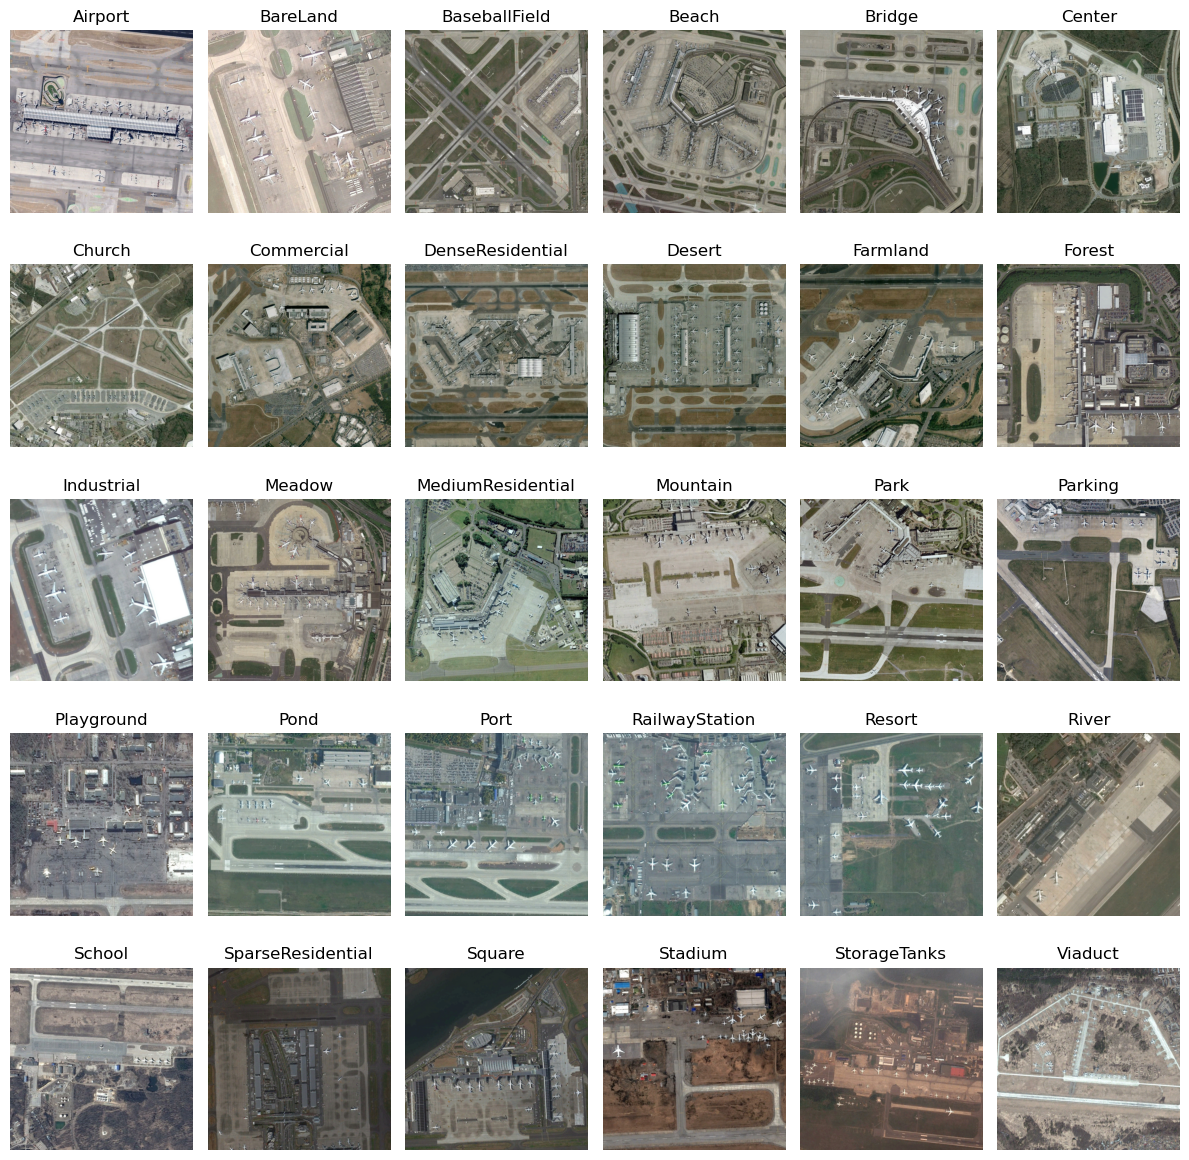

In [4]:
# Get class names from the original dataset
class_names = full_dataset.classes  # ✅ Fix: Use full_dataset instead of train_dataset

# Visualize one image per class
fig, axes = plt.subplots(5, 6, figsize=(12, 12))
axes = axes.ravel()

for idx, class_name in enumerate(class_names):
    class_idx = full_dataset.class_to_idx[class_name]  # Use full_dataset
    img_path, _ = full_dataset.samples[idx]  # Use full_dataset
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].set_title(class_name)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

In [5]:
# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Model

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models

num_classes = len(class_names)

class SEBlock(nn.Module):
    """Squeeze-and-Excitation Block"""
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y

class MultiScaleResBlock(nn.Module):
    """Multi-scale residual blocks"""
    def __init__(self, in_channels):
        super(MultiScaleResBlock, self).__init__()
        self.conv3x3 = nn.Conv2d(in_channels, 512, kernel_size=3, padding=1)  # The output channel is changed to 512
        self.conv5x5 = nn.Conv2d(in_channels, 512, kernel_size=5, padding=2)  # The output channel is changed to 512
        self.conv7x7 = nn.Conv2d(in_channels, 1024, kernel_size=7, padding=3)  # The output channel is changed to 1024
        self.attention = SEBlock(2048)  # 3×512 + 1024 = 2048
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        f3 = self.conv3x3(x)
        f5 = self.conv5x5(x)
        f7 = self.conv7x7(x)
        fused = torch.cat([f3, f5, f7], dim=1)  # The number of spliced channels is 2048
        fused = self.attention(fused)
        fused = self.dropout(fused)
        return x + fused  # Residual connections

class RemoteSensingModel(nn.Module):
    """MS-ResNet model"""
    def __init__(self, num_classes=num_classes):  # WHU-RS19 has 19 categories
        super(RemoteSensingModel, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.multi_scale_block = MultiScaleResBlock(2048)  # The number of ResNet-50 last layer output channels
        self.fc = nn.Linear(2048, num_classes)

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.multi_scale_block(x)
        x = self.resnet.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [15]:
# import timm
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torchvision.models as models

# num_classes = len(class_names)

# class SpanConv(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
#         super(SpanConv, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,
#                               stride=stride, padding=padding)

#     def forward(self, x):
#         return self.conv(x)

# class SPDConv(nn.Module):
#     def __init__(self, in_channels, out_channels, block_size):
#         super(SPDConv, self).__init__()
#         self.block_size = block_size
#         self.conv = nn.Conv2d(in_channels * block_size * block_size, out_channels, kernel_size=3, padding=1)

#     def forward(self, x):
#         B, C, H, W = x.shape
#         pad_h = (self.block_size - H % self.block_size) % self.block_size
#         pad_w = (self.block_size - W % self.block_size) % self.block_size
#         x = F.pad(x, (0, pad_w, 0, pad_h), mode='constant', value=0)

#         new_H, new_W = (H + pad_h) // self.block_size, (W + pad_w) // self.block_size
#         x = x.view(B, C, new_H, self.block_size, new_W, self.block_size)
#         x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
#         x = x.view(B, C * self.block_size * self.block_size, new_H, new_W)
#         return self.conv(x)

# class SEBlock(nn.Module):
#     """Squeeze-and-Excitation Block"""
#     def __init__(self, channel, reduction=16):
#         super(SEBlock, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool2d(1)
#         self.fc = nn.Sequential(
#             nn.Linear(channel, channel // reduction),
#             nn.ReLU(inplace=True),
#             nn.Linear(channel // reduction, channel),
#             nn.Sigmoid()
#         )

#     def forward(self, x):
#         b, c, _, _ = x.size()
#         y = self.avg_pool(x).view(b, c)
#         y = self.fc(y).view(b, c, 1, 1)
#         return x * y

# class MultiScaleResBlock(nn.Module):
#     def __init__(self, in_channels):
#         super(MultiScaleResBlock, self).__init__()
#         self.span3x3 = SpanConv(in_channels, 512, kernel_size=3, padding=1)
#         self.span5x5 = SpanConv(in_channels, 512, kernel_size=5, padding=2)
#         self.span7x7 = SpanConv(in_channels, 512, kernel_size=7, padding=3)
#         self.spdconv = SPDConv(in_channels, 512, block_size=2)  # Reduce to 512 for balance
#         self.attention = SEBlock(2048)
#         self.dropout = nn.Dropout(0.5)

#     def forward(self, x):
#         f3 = self.span3x3(x)
#         f5 = self.span5x5(x)
#         f7 = self.span7x7(x)
#         f_spd = self.spdconv(x)

#         # Resize all to the smallest feature map size (e.g., f_spd)
#         min_h = min(f.shape[2] for f in [f3, f5, f7, f_spd])
#         min_w = min(f.shape[3] for f in [f3, f5, f7, f_spd])

#         f3 = F.interpolate(f3, size=(min_h, min_w), mode='bilinear', align_corners=False)
#         f5 = F.interpolate(f5, size=(min_h, min_w), mode='bilinear', align_corners=False)
#         f7 = F.interpolate(f7, size=(min_h, min_w), mode='bilinear', align_corners=False)
#         f_spd = F.interpolate(f_spd, size=(min_h, min_w), mode='bilinear', align_corners=False)

#         fused = torch.cat([f3, f5, f7, f_spd], dim=1)
#         fused = self.attention(fused)
#         fused = self.dropout(fused)
#         return x + F.interpolate(fused, size=x.shape[2:], mode='bilinear', align_corners=False)


# class RemoteSensingModel(nn.Module):
#     """MS-ResNet model"""
#     def __init__(self, num_classes=num_classes):  # WHU-RS19 has 19 categories
#         super(RemoteSensingModel, self).__init__()
#         self.resnet = models.resnet50(pretrained=True)
#         self.multi_scale_block = MultiScaleResBlock(2048)  # The number of ResNet-50 last layer output channels
#         self.fc = nn.Linear(2048, num_classes)

#     def forward(self, x):
#         x = self.resnet.conv1(x)
#         x = self.resnet.bn1(x)
#         x = self.resnet.relu(x)
#         x = self.resnet.maxpool(x)

#         x = self.resnet.layer1(x)
#         x = self.resnet.layer2(x)
#         x = self.resnet.layer3(x)
#         x = self.resnet.layer4(x)

#         x = self.multi_scale_block(x)
#         x = self.resnet.avgpool(x)
#         x = torch.flatten(x, 1)
#         x = self.fc(x)

#         return x

c:\Users\Pachigo\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pachigo\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Pachigo\AppData\Local\Temp\ipykernel_17964\1958118636.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  class_weights_tensor = torch.tensor(class_weights, dtype=torch.fl


Epoch [1/100] - Loss: 1.1441, Train Acc: 0.7076, Val Acc: 0.8687



Epoch [2/100] - Loss: 0.4140, Train Acc: 0.8789, Val Acc: 0.9013



Epoch [3/100] - Loss: 0.2677, Train Acc: 0.9191, Val Acc: 0.9453



Epoch [4/100] - Loss: 0.2157, Train Acc: 0.9369, Val Acc: 0.9407



Epoch [5/100] - Loss: 0.1439, Train Acc: 0.9540, Val Acc: 0.9513



Epoch [6/100] - Loss: 0.0809, Train Acc: 0.9730, Val Acc: 0.9473



Epoch [7/100] - Loss: 0.0498, Train Acc: 0.9859, Val Acc: 0.9553



Epoch [8/100] - Loss: 0.0360, Train Acc: 0.9891, Val Acc: 0.9627



Epoch [9/100] - Loss: 0.0209, Train Acc: 0.9937, Val Acc: 0.9613



Epoch [10/100] - Loss: 0.0172, Train Acc: 0.9956, Val Acc: 0.9633



Epoch [11/100] - Loss: 0.6065, Train Acc: 0.8480, Val Acc: 0.9027



Epoch [12/100] - Loss: 0.2231, Train Acc: 0.9309, Val Acc: 0.9113



Epoch [13/100] - Loss: 0.1547, Train Acc: 0.9504, Val Acc: 0.9420



Epoch [14/100] - Loss: 0.1326, Train Acc: 0.9573, Val Acc: 0.9293



Epoch [15/100] - Loss: 0.1138, Train Acc: 0.9619, Val Acc: 0.9347
Early stopping triggered after 15 epochs! Best Validation Accuracy: 0.9633


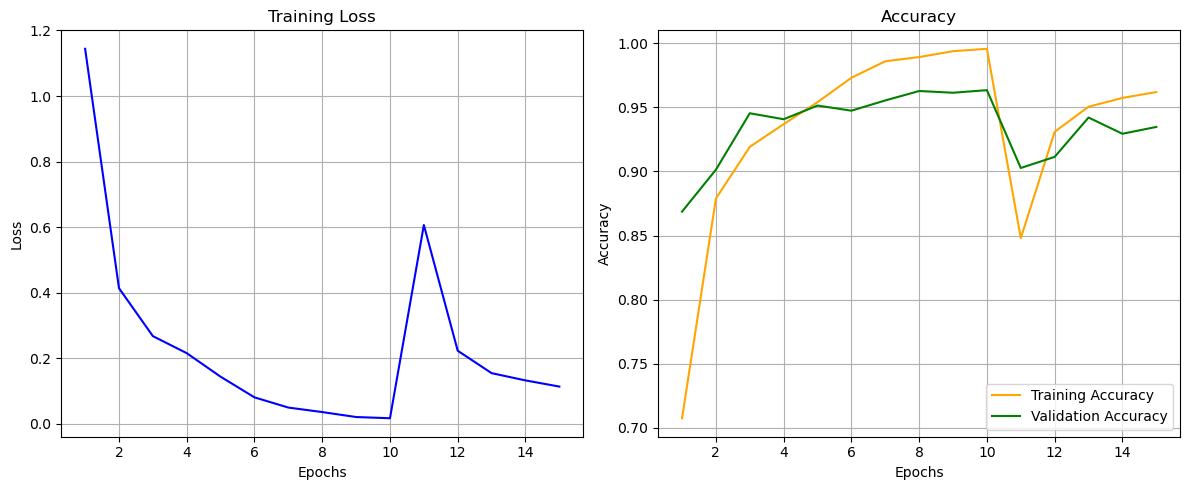

In [16]:
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm

# Initialize model
num_epochs = 100
model = RemoteSensingModel().to(device)

# Convert to a tensor for PyTorch
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use in loss function
criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device))

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # L2 regularization

# Cosine Annealing with Warm Restarts
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10, verbose=True):
    best_acc = 0.0
    train_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        train_progress = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)

        for batch_idx, (images, labels) in enumerate(train_progress):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            train_progress.set_postfix(loss=loss.item())

            # Update scheduler per batch (Optional)
            scheduler.step(epoch + batch_idx / len(train_loader))

        train_acc = correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        correct = 0
        total = 0

        val_progress = tqdm(val_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_progress:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        val_accuracies.append(val_acc)

        if verbose:
            print(f"\nEpoch [{epoch+1}/{num_epochs}] - Loss: {train_losses[-1]:.4f}, "
                  f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), "AID_Trained.pth")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs! Best Validation Accuracy: {best_acc:.4f}")
            break

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy', color='orange')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='green')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=num_epochs, patience=5, verbose=True)

In [8]:
# Initialize model
num_epochs = 100
model = RemoteSensingModel().to(device)

# Load the best model
model.load_state_dict(torch.load("AID_Trained.pth"))
model.eval()

c:\Users\Pachigo\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pachigo\anaconda3\envs\pytorch_gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Pachigo\AppData\Local\Temp\ipykernel_8468\1884826904.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://gith

RemoteSensingModel(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


## Evaluation

In [10]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate model
y_true = []
y_pred = []
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute standard metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')  # Average over all classes
recall = recall_score(y_true, y_pred, average='macro')  # Equivalent to Sensitivity
f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

# Compute sensitivity and specificity per class
num_classes = conf_matrix.shape[0]
sensitivity_per_class = []
specificity_per_class = []

for i in range(num_classes):
    TP = conf_matrix[i, i]
    FN = sum(conf_matrix[i, :]) - TP
    FP = sum(conf_matrix[:, i]) - TP
    TN = conf_matrix.sum() - (TP + FP + FN)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall for this class
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

    sensitivity_per_class.append(sensitivity)
    specificity_per_class.append(specificity)

# Compute macro-averaged sensitivity and specificity
macro_sensitivity = sum(sensitivity_per_class) / num_classes
macro_specificity = sum(specificity_per_class) / num_classes

# Print results with four significant figures
print(f"Accuracy: {accuracy:.4g}")
print(f"Precision: {precision:.4g}")
print(f"Recall (Sensitivity): {recall:.4g}")  # Equivalent to macro-averaged sensitivity
print(f"Macro-Averaged Specificity: {macro_specificity:.4g}")
print(f"F1 Score: {f1:.4g}")

Accuracy: 0.99
Precision: 0.9897
Recall (Sensitivity): 0.9888
Macro-Averaged Specificity: 0.9997
F1 Score: 0.9891


In [ ]:
# Extract class names when using Subset
class_names = list(test_loader.dataset.dataset.class_to_idx.keys())

# Generate classification report
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification Report:\n")
print(report)

Classification Report:

                   precision    recall  f1-score   support

          Airport     0.9855    1.0000    0.9927        68
         BareLand     1.0000    0.9787    0.9892        47
    BaseballField     1.0000    1.0000    1.0000        42
            Beach     1.0000    1.0000    1.0000        63
           Bridge     1.0000    0.9762    0.9880        42
           Center     0.9429    0.9167    0.9296        36
           Church     1.0000    0.9783    0.9890        46
       Commercial     0.9600    1.0000    0.9796        48
 DenseResidential     1.0000    0.9867    0.9933        75
           Desert     0.9787    1.0000    0.9892        46
         Farmland     1.0000    1.0000    1.0000        55
           Forest     1.0000    1.0000    1.0000        35
       Industrial     0.9259    1.0000    0.9615        50
           Meadow     1.0000    1.0000    1.0000        44
MediumResidential     1.0000    1.0000    1.0000        51
         Mountain     1.0000   

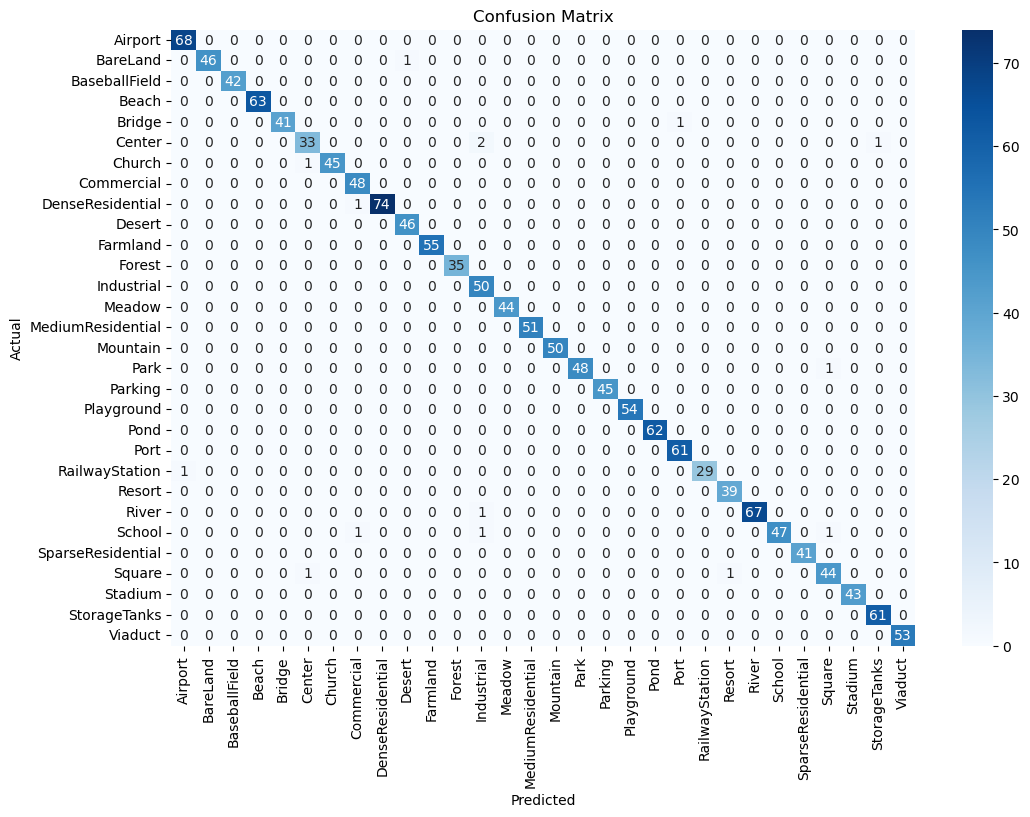

In [12]:
# Display confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## ROC and Precision-Recall

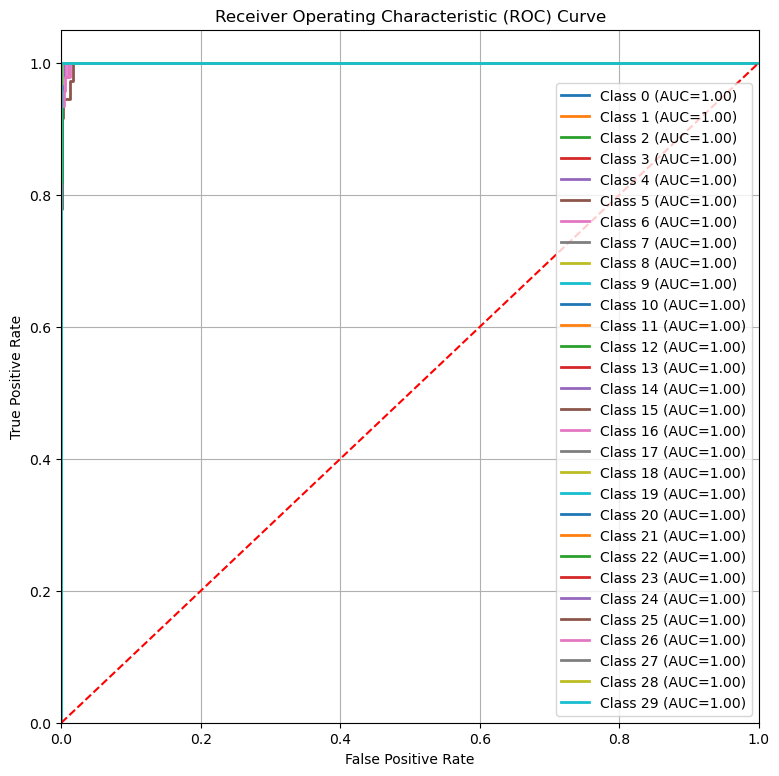

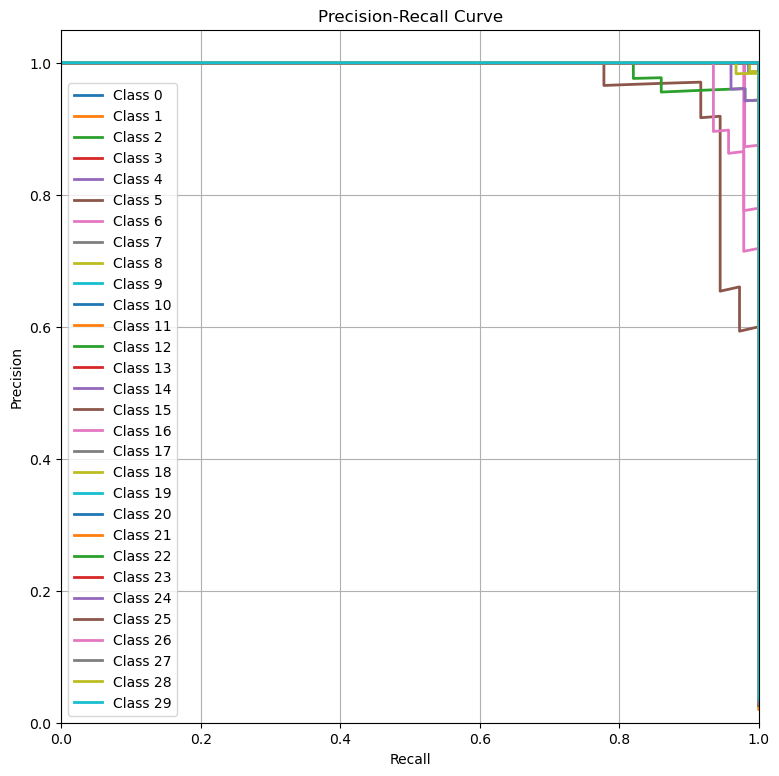

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Evaluate model
y_true = []  # True labels
y_scores = []  # Predicted probabilities

model.eval()
with torch.no_grad():  # Disable gradient tracking
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Get predicted probabilities for all classes
        probabilities = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert to numpy

        y_true.extend(labels.cpu().numpy())
        y_scores.extend(probabilities)  # Store probabilities for all classes

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_scores = np.array(y_scores)

# Get number of classes
num_classes = y_scores.shape[1]

# Initialize arrays to store metrics
roc_auc = []
precision = []
recall = []

# Plot ROC curves
plt.figure(figsize=(9, 9))

for i in range(num_classes):
    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve((y_true == i).astype(int), y_scores[:, i])  # Convert to binary
    roc_auc.append(auc(fpr, tpr))
    
    # Plot ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC={roc_auc[i]:.2f})')

# Plot random classifier reference line
plt.plot([0, 1], [0, 1], color='red', linestyle='--')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Plot Precision-Recall curves
plt.figure(figsize=(9, 9))

for i in range(num_classes):
    # Compute Precision-Recall curve
    p, r, _ = precision_recall_curve((y_true == i).astype(int), y_scores[:, i])
    precision.append(p)
    recall.append(r)

    # Plot Precision-Recall curve
    plt.plot(r, p, lw=2, label=f'Class {i}')

# Formatting
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()

## LIME Visualization

c:\Users\Pachigo\anaconda3\envs\pytorch_gpu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


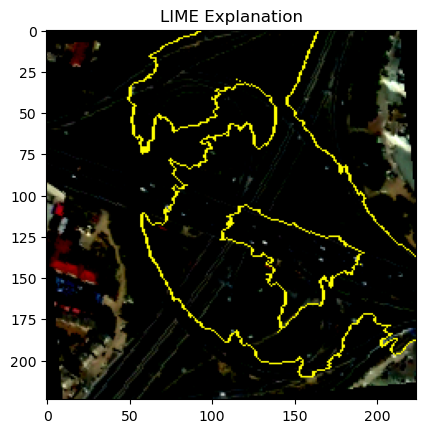

In [21]:
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries

# Apply LIME
explainer = LimeImageExplainer()
def batch_predict(images):
    model.eval()
    images = torch.tensor(images).permute(0, 3, 1, 2).float().to(device)
    outputs = model(images)
    return outputs.detach().cpu().numpy()

idx = 0
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


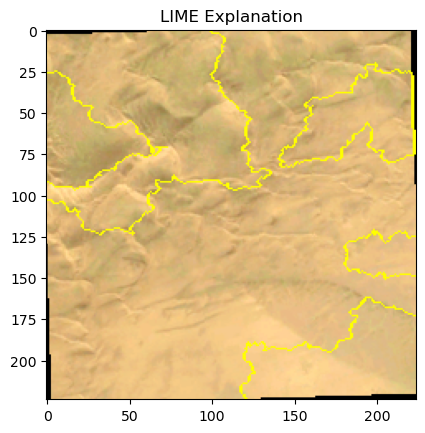

In [22]:
idx = 31
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:29<00:00,  4.77it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].


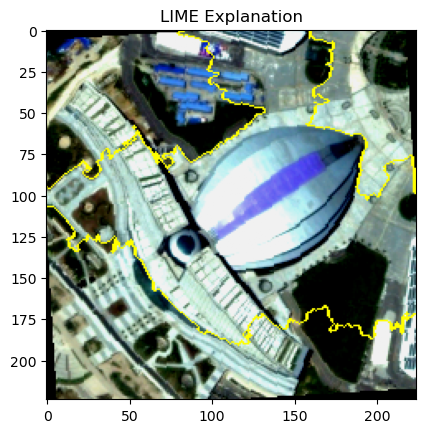

In [23]:
idx = 61
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


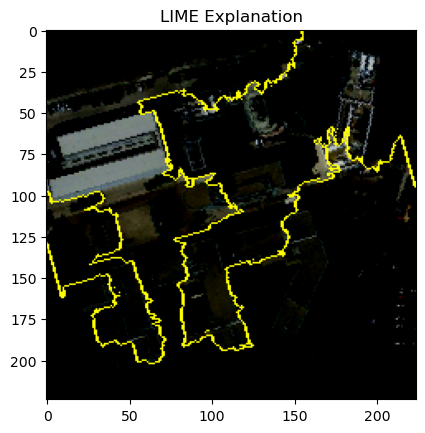

In [24]:
idx = 91
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].


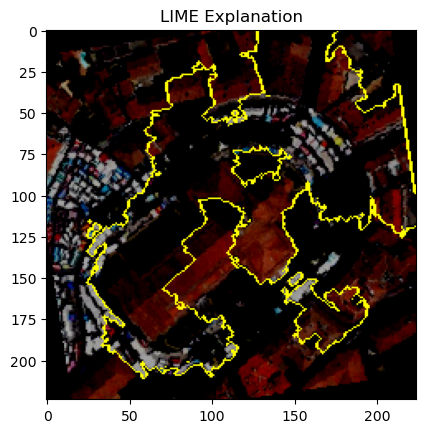

In [25]:
idx = 121
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


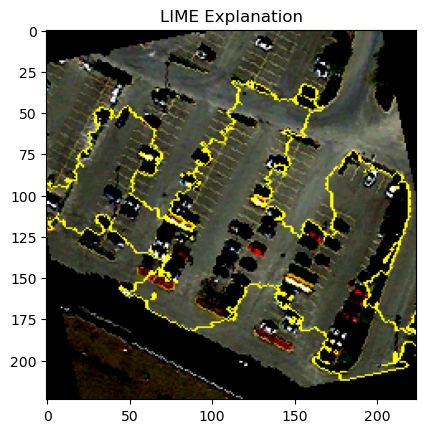

In [26]:
idx = 151
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

100%|██████████| 1000/1000 [03:30<00:00,  4.76it/s]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


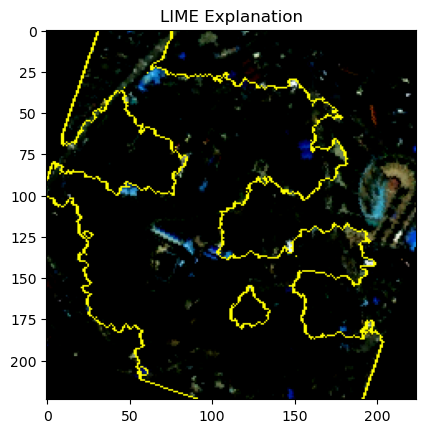

In [27]:
idx = 181
image, _ = test_dataset[idx]
explanation = explainer.explain_instance(image.permute(1, 2, 0).numpy(), batch_predict, top_labels=5, hide_color=0, num_samples=1000)
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp, mask))
plt.title("LIME Explanation")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.372493179887011..0.5052788973587793].


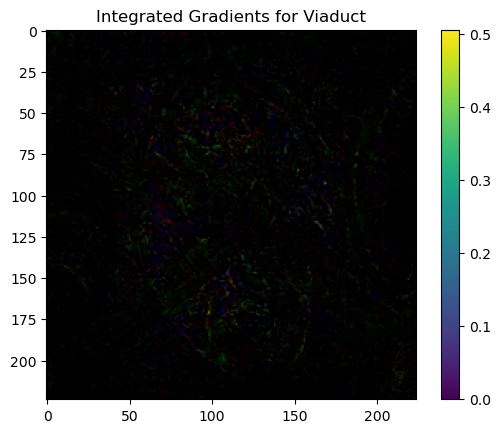

In [28]:
from captum.attr import IntegratedGradients
import torch
import matplotlib.pyplot as plt

# Move model to the same device as input
model = model.to(device)

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Select a test image
idx = 0
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.36964819464135595..0.48800180385738606].


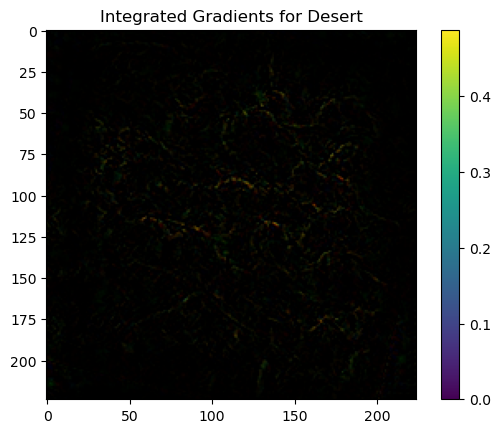

In [29]:
# Select a test image
idx = 31
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.619837028911705..0.8471324392391582].


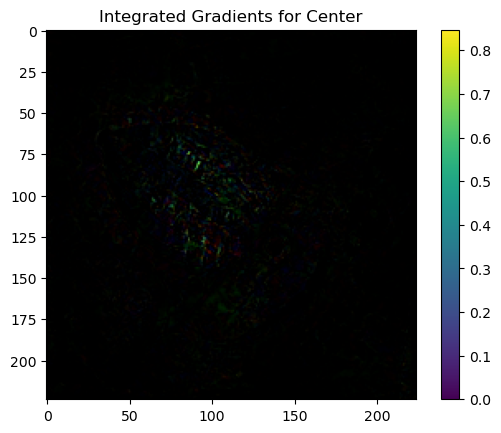

In [30]:
# Select a test image
idx = 61
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.12361772819708727..0.11540374297714473].


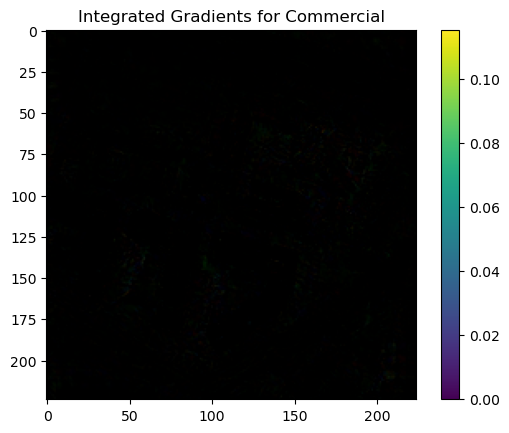

In [31]:
# Select a test image
idx = 91
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4533044329819094..0.39007598011282457].


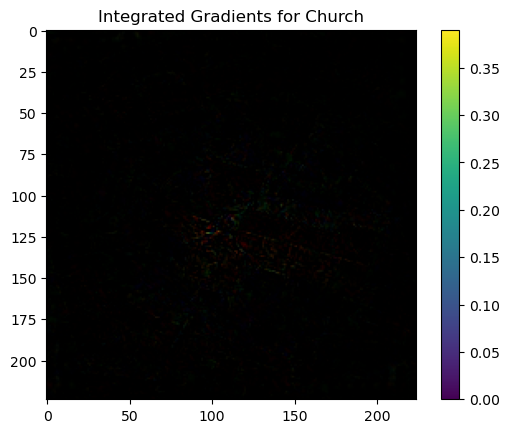

In [32]:
# Select a test image
idx = 121
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5243441117894213..0.5473284530580406].


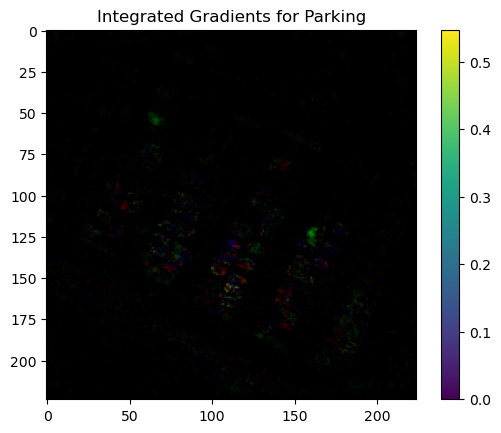

In [33]:
# Select a test image
idx = 151
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4132677399578969..0.36177545809243994].


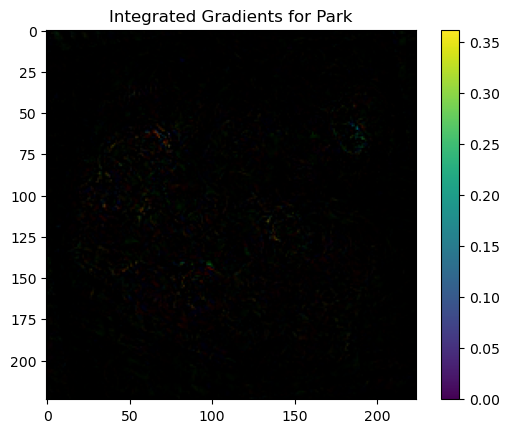

In [34]:
# Select a test image
idx = 181
image, label = test_dataset[idx]
image = image.unsqueeze(0).to(device)  # Ensure the image is on the same device as the model

# Compute attributions
attributions = ig.attribute(image, target=label, baselines=image * 0, method="gausslegendre")

# Convert attributions to NumPy and ensure correct shape
attributions_np = attributions.squeeze().detach().cpu().numpy().transpose(1, 2, 0)  # Convert (3, 224, 224) → (224, 224, 3)

# Plot the attributions
plt.imshow(attributions_np)
plt.title(f"Integrated Gradients for {class_names[label]}")
plt.colorbar()
plt.show()

## Attention Visualisation

In [35]:
@torch.no_grad()
def visualize_attention(model, image_tensor):
    model.eval()

    # Step 1: tokenize
    x = model.backbone.patch_embed(image_tensor)
    B, N, C = x.shape
    cls_token = model.backbone.cls_token.expand(B, -1, -1)
    x = torch.cat((cls_token, x), dim=1)
    x = x + model.backbone.pos_embed[:, :x.size(1)]
    x = model.backbone.pos_drop(x)

    # Step 2: manually compute attention weights
    attn_block = model.backbone.blocks[0].attn
    qkv = attn_block.qkv(x).reshape(B, x.shape[1], 3, attn_block.num_heads, attn_block.head_dim).permute(2, 0, 3, 1, 4)
    q, k, v = qkv[0], qkv[1], qkv[2]  # [B, heads, tokens, head_dim]
    attn_scores = (q @ k.transpose(-2, -1)) * attn_block.scale
    attn_probs = attn_scores.softmax(dim=-1)  # [B, heads, tokens, tokens]

    # Step 3: extract mean attention from CLS token
    attn_map = attn_probs.mean(dim=1)[0, 0, 1:]  # Mean over heads, CLS → patches
    num_patches = int(attn_map.size(0) ** 0.5)
    attn_map = attn_map.view(num_patches, num_patches).cpu()

    # Step 4: plot
    plt.imshow(attn_map, cmap='viridis')
    plt.title('CLS Attention (Averaged Heads)')
    plt.colorbar()
    plt.axis('off')
    plt.show()

In [36]:
# from torchvision import transforms
# from PIL import Image

# # 1. Load and preprocess image
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(
#         mean=[0.5, 0.5, 0.5],
#         std=[0.5, 0.5, 0.5]
#     )
# ])

# img = Image.open("commercial_50.jpg").convert("RGB")
# input_tensor = transform(img).unsqueeze(0).to(device)  # Add batch and move to device

# # 2. Call visualization function
# visualize_attention(model, input_tensor)